# Prophet model for energy demand forecasting

This notebook mirrors the LSTM experiment setup and evaluates Prophet on the same forecast horizon.
It loads the preprocessed numpy arrays metadata to keep window size and horizon consistent.

In [7]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import pickle

from sklearn.metrics import mean_absolute_error, root_mean_squared_error

from prophet import Prophet


## Load preprocessed arrays and metadata
The stored window size and forecast horizon are reused so evaluation matches the LSTM setup.


In [2]:
DATA_PATH = Path("../../data/processed")
EXPERIMENT_NAME = "fs_06_load_calendar_future_weather"
OUTPUT_PATH = DATA_PATH / "ml_data" / EXPERIMENT_NAME

# Load numpy arrays (same as LSTM notebook)
scalers_dir = OUTPUT_PATH / "scalers"

X_train_seq = np.load(OUTPUT_PATH / "X_train.npy")
y_train_seq = np.load(OUTPUT_PATH / "y_train.npy")
X_val_seq = np.load(OUTPUT_PATH / "X_val.npy")
y_val_seq = np.load(OUTPUT_PATH / "y_val.npy")
X_test_seq = np.load(OUTPUT_PATH / "X_test.npy")
y_test_seq = np.load(OUTPUT_PATH / "y_test.npy")

with open(scalers_dir / "y_scaler.pkl", "rb") as f:
    y_scaler = pickle.load(f)

with open(OUTPUT_PATH / "meta.json", "r") as f:
    meta = json.load(f)

WINDOW_SIZE = int(meta["window_size"])
FORECAST_HORIZON = int(meta["forecast_horizon"])
FEATURE_NAMES = meta["feature_names"]

print(f"Window size: {WINDOW_SIZE}, Horizon: {FORECAST_HORIZON}")
print(f"Train/Val/Test sequences: {len(y_train_seq)}/{len(y_val_seq)}/{len(y_test_seq)}")


Window size: 672, Horizon: 96
Train/Val/Test sequences: 164214/39863/39863


## Load full dataframe and prepare Prophet input
Prophet expects columns `ds` (timestamp) and `y` (target). Optional regressors are added if available.


In [31]:
# Load the full feature dataframe
df = pd.read_parquet(DATA_PATH / "data_combined.parquet")

TARGET = "actual_load_mw"
regressors = [c for c in FEATURE_NAMES if c != TARGET and c in df.columns]

# Prepare Prophet dataframe
prophet_df = df.copy()
prophet_df = prophet_df.rename(columns={TARGET: "y"})
prophet_df["ds"] = prophet_df.index
prophet_df = prophet_df.reset_index(drop=True)

print(f"Prophet regressors: {len(regressors)}")
prophet_df.head()


Prophet regressors: 18


,y,t2m,ssrd,tp,wind_speed,t2m_future,ssrd_future,tp_future,wind_speed_future,is_weekday,is_holiday,sin_tod,cos_tod,sin_dow,cos_dow,sin_doy,cos_doy,is_dst,is_dst_transition_day,ds
0,5256.0,279.426453,0.0,3.671894e-10,0.693914,277.421722,0.0,0.000000e+00,1.758537,True,0,0.000000,1.000000,0.0,1.0,-0.999917,-0.012910,1,1,2018-10-01 00:00:00+00:00
1,5204.0,279.426453,0.0,3.671894e-10,0.693914,277.421722,0.0,0.000000e+00,1.758537,True,0,0.065403,0.997859,0.0,1.0,-0.999919,-0.012731,1,1,2018-10-01 00:15:00+00:00
2,5178.0,279.426453,0.0,3.671894e-10,0.693914,277.421722,0.0,0.000000e+00,1.758537,True,0,0.130526,0.991445,0.0,1.0,-0.999921,-0.012551,1,1,2018-10-01 00:30:00+00:00
3,5151.0,279.426453,0.0,3.671894e-10,0.693914,277.421722,0.0,0.000000e+00,1.758537,True,0,0.195090,0.980785,0.0,1.0,-0.999923,-0.012372,1,1,2018-10-01 00:45:00+00:00
4,5187.0,279.108917,0.0,3.959738e-08,0.583597,277.252350,0.0,6.201566e-08,1.709355,True,0,0.258819,0.965926,0.0,1.0,-0.999926,-0.012193,1,1,2018-10-01 01:00:00+00:00


## Split by saved date ranges
The same train/validation/test date ranges from preprocessing are applied.


In [32]:
# Split using saved metadata date ranges
train_start = pd.to_datetime(meta["train_date_range"]["start"])
train_end = pd.to_datetime(meta["train_date_range"]["end"])
val_start = pd.to_datetime(meta["val_date_range"]["start"])
val_end = pd.to_datetime(meta["val_date_range"]["end"])
test_start = pd.to_datetime(meta["test_date_range"]["start"])
test_end = pd.to_datetime(meta["test_date_range"]["end"])

def slice_by_range(df_in, start, end):
    mask = (df_in["ds"] >= start) & (df_in["ds"] <= end)
    return df_in.loc[mask].copy()

train_df = slice_by_range(prophet_df, train_start, train_end)
val_df = slice_by_range(prophet_df, val_start, val_end)
test_df = slice_by_range(prophet_df, test_start, test_end)

print(f"Train: {train_df.shape}, Val: {val_df.shape}, Test: {test_df.shape}")


Train: (164981, 20), Val: (40630, 20), Test: (40630, 20)


In [ ]:
train_df["ds"]=train_df["ds"].dt.tz_convert(None)
val_df["ds"]=val_df["ds"].dt.tz_convert(None)
test_df["ds"]=test_df["ds"].dt.tz_convert(None)

## Model helpers
Define model configuration and helper functions for sequence-style evaluation.


In [ ]:
def build_prophet_model(regressors):
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=True,
    )

    # 15-minute data: add higher-order daily seasonality
    model.add_seasonality(name="daily_highres", period=1, fourier_order=20)

    for reg in regressors:
        model.add_regressor(reg)

    return model

def create_sequences_1d(y, window_size, forecast_horizon):
    y = np.asarray(y)
    seq = []
    for i in range(len(y) - window_size - forecast_horizon + 1):
        seq.append(y[i + window_size : i + window_size + forecast_horizon])
    return np.array(seq)

def evaluate_sequences(y_true_seq, y_pred_seq):
    n = min(len(y_true_seq), len(y_pred_seq))
    y_true_seq = y_true_seq[:n]
    y_pred_seq = y_pred_seq[:n]

    mae = mean_absolute_error(y_true_seq, y_pred_seq)
    rmse = root_mean_squared_error(y_true_seq, y_pred_seq)

    print(f"MAE:  {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")

    horizons = [1, 4, 12, 24, 48, 96]
    for h in horizons:
        if h <= y_true_seq.shape[1]:
            h_rmse = root_mean_squared_error(y_true_seq[:, h-1], y_pred_seq[:, h-1])
            print(f"RMSE h{h}: {h_rmse:.3f}")

    return mae, rmse


## Temporal cross-validation with MLflow
TimeSeriesSplit is used on the training data to evaluate multiple folds and log metrics.


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
import mlflow
from prophet.serialize import model_to_json

mlflow.set_experiment("load_forecasting_prophet")

# Use train+val for CV, keep test for final evaluation
cv_df = pd.concat([train_df, val_df], axis=0, ignore_index=True)

N_SPLITS = 5
tscv = TimeSeriesSplit(n_splits=N_SPLITS)

best_rmse = float("inf")
best_model_json = None
best_fold = None

with mlflow.start_run(run_name="prophet_tscv"):
    mlflow.log_params({
        "n_splits": N_SPLITS,
        "window_size": WINDOW_SIZE,
        "forecast_horizon": FORECAST_HORIZON,
        "n_regressors": len(regressors),
    })

    for fold, (train_idx, val_idx) in enumerate(tscv.split(cv_df)):
        fold_train = cv_df.iloc[train_idx].copy()
        fold_val = cv_df.iloc[val_idx].copy()

        model = build_prophet_model(regressors)
        model.fit(fold_train)

        future_val = fold_val[["ds"] + regressors].copy()
        val_forecast = model.predict(future_val)

        y_val_true = fold_val["y"].values
        y_val_pred = val_forecast["yhat"].values

        y_val_true_seq = create_sequences_1d(y_val_true, WINDOW_SIZE, FORECAST_HORIZON)
        y_val_pred_seq = create_sequences_1d(y_val_pred, WINDOW_SIZE, FORECAST_HORIZON)

        mae = mean_absolute_error(y_val_true_seq, y_val_pred_seq)
        rmse = root_mean_squared_error(y_val_true_seq, y_val_pred_seq)

        mlflow.log_metric("val_mae", mae, step=fold)
        mlflow.log_metric("val_rmse", rmse, step=fold)

        horizons = [1, 4, 12, 24, 48, 96]
        for h in horizons:
            if h <= y_val_true_seq.shape[1]:
                h_rmse = root_mean_squared_error(y_val_true_seq[:, h-1], y_val_pred_seq[:, h-1])
                mlflow.log_metric(f"val_rmse_h{h}", h_rmse, step=fold)

        if rmse < best_rmse:
            best_rmse = rmse
            best_fold = fold
            best_model_json = model_to_json(model)

    mlflow.log_metric("best_val_rmse", best_rmse)
    if best_model_json is not None:
        best_path = OUTPUT_PATH / "prophet_best_model.json"
        best_path.write_text(best_model_json)
        mlflow.log_artifact(str(best_path))
        mlflow.log_param("best_fold", best_fold)


   ## Refit on train+val, evaluate on test
Final fit uses more data, then evaluates on the test period with the same horizon metrics.


In [40]:
# Fit on train, evaluate on validation
model = build_prophet_model(regressors)
model.fit(train_df)

future_val = val_df[["ds"] + regressors].copy()
val_forecast = model.predict(future_val)

y_val_true = val_df["y"].values
y_val_pred = val_forecast["yhat"].values

y_val_true_seq = create_sequences_1d(y_val_true, WINDOW_SIZE, FORECAST_HORIZON)
y_val_pred_seq = create_sequences_1d(y_val_pred, WINDOW_SIZE, FORECAST_HORIZON)

print("Validation metrics (sequence-based):")
_ = evaluate_sequences(y_val_true_seq, y_val_pred_seq)


11:03:41 - cmdstanpy - INFO - Chain [1] start processing
11:07:51 - cmdstanpy - INFO - Chain [1] done processing


Validation metrics (sequence-based):
MAE:  668.692
RMSE: 803.020
RMSE h1: 800.665
RMSE h4: 800.860
RMSE h12: 801.433
RMSE h24: 802.283
RMSE h48: 803.469
RMSE h96: 804.330


## Quick visual check (optional)
Plot a short slice of the test forecast to compare actual vs predicted values.


In [45]:
# Refit on train + validation, evaluate on test
train_val_df = pd.concat([train_df, val_df], axis=0, ignore_index=True)
model = build_prophet_model(regressors)
model.fit(train_val_df)

future_test = test_df[["ds"] + regressors].copy()
test_forecast = model.predict(future_test)

y_test_true = test_df["y"].values
y_test_pred = test_forecast["yhat"].values

y_test_true_seq = create_sequences_1d(y_test_true, WINDOW_SIZE, FORECAST_HORIZON)
y_test_pred_seq = create_sequences_1d(y_test_pred, WINDOW_SIZE, FORECAST_HORIZON)

print("Test metrics (sequence-based):")
_ = evaluate_sequences(y_test_true_seq, y_test_pred_seq)


11:24:38 - cmdstanpy - INFO - Chain [1] start processing
11:28:18 - cmdstanpy - INFO - Chain [1] done processing


Test metrics (sequence-based):
MAE:  423.393
RMSE: 526.291
RMSE h1: 526.286
RMSE h4: 526.290
RMSE h12: 526.285
RMSE h24: 526.374
RMSE h48: 526.292
RMSE h96: 526.254


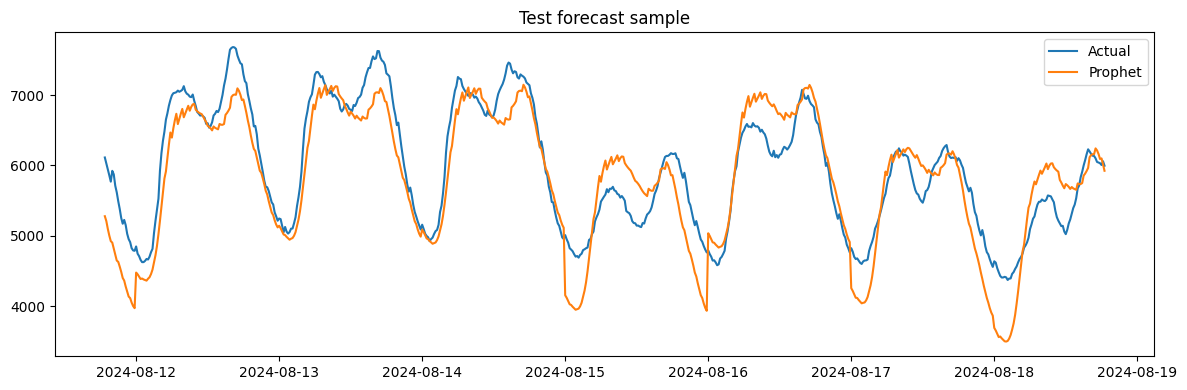

In [ ]:
import matplotlib.pyplot as plt

plot_len = 7 * 96  # one week
plot_df = test_df.iloc[:plot_len].copy()
plot_df["yhat"] = test_forecast["yhat"].values[:plot_len]

plt.figure(figsize=(12, 4))
plt.plot(plot_df["ds"], plot_df["y"], label="Actual")
plt.plot(plot_df["ds"], plot_df["yhat"], label="Prophet")
plt.legend()
plt.title("Test forecast sample")
plt.tight_layout()
plt.show()
